In [1]:
!pip3 install git+https://github.com/holounic/Bayesian-Optimization.git
!pip3 install cma

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/holounic/Bayesian-Optimization.git to /tmp/pip-req-build-20ew83uv
  Running command git clone -q https://github.com/holounic/Bayesian-Optimization.git /tmp/pip-req-build-20ew83uv
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Cloning https://github.com/holounic/pyDOE to /tmp/pip-install-2i6l6361/pydoe_ebe1e092e7de454089fe7b462b653cb8
  Running command git clone -q https://github.com/holounic/pyDOE /tmp/pip-install-2i6l6361/pydoe_ebe1e092e7de454089fe7b462b653cb8
     |████████████████████████████████| 62 kB 1.7 MB/s 
     |████████████████████████████████| 316 kB 26.6 MB/s 
  Created wheel for bayes-optim: filename=bayes_optim-0.2.7-py3-none-any.whl size=145056 sha256=775c85715e0a280b8d7a01efae41dcf3739dc044bc371e0e0f0e71a10c488e65
  Stored in directory: /tmp/pip-ephem-wheel-cache-

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import cma

from pyDOE import lhs

from bayes_optim import BO
from bayes_optim.search_space import RealSpace
from bayes_optim.surrogate import GaussianProcess, trend

from benchmark.bbobbenchmarks import F21

np.random.seed(1111)

dim = 2
lb, ub = -5, 5

mean = trend.constant_trend(dim, beta=None)
thetaL = 1e-10 * (ub - lb) * np.ones(dim)
thetaU = 10 * (ub - lb) * np.ones(dim)
theta0 = np.random.rand(dim) * (thetaU - thetaL) + thetaL

max_FEs = 2**6
verbose = False

n_samples = 30000

max_cma_iter = 20

obj_func = F21(1)

space = RealSpace([lb, ub]) * dim
samples = space.sample(n_samples)
values = obj_func(samples)

In [3]:
opt_color, found_color, initial_color = "green", "red", "blue"

def plot(points, colors, ax=plt, outline=False, marker='o', marker_size=30):
    transposed = np.transpose(points)
    if outline:
        ax.scatter(transposed[0], transposed[1], color="none", edgecolor=colors, marker=marker, s=marker_size)
    else:
        ax.scatter(transposed[0], transposed[1], c=colors, marker=marker, s=marker_size)


# plot DoE, optimum, found by the BO, and global optimum on the surface of the function
def plot_result(func, samples, values, result, ax):
  plot(samples, values, ax=ax, outline=False)
  if result["initial_points"] is not None:
    plot(result["initial_points"], ["blue"] * result["initial_points"].shape[0], ax=ax, marker='^')
  ax.set_title(f'{result.get("description", "regret")}: {result["regret"]}', size=6)
  plot([func._getxopt(), result["found_x"]], [opt_color, found_color], ax=ax, marker='s')


# plot initial points provided to the CMA-ES and DoE, found by it, on the surface of the function
def plot_initial_found(func, samples, values, initial, found, result):
  fig, axs = plt.subplots(1, 2)
  fig.suptitle("Objective function " + func.__class__.__name__, fontsize=8)
  plot(samples, values, ax=axs[0], outline=False) # plot surface
  axs[0].set_title('Initial individual for CMA-ES')
  plot(samples, values, ax=axs[1], outline=False)
  axs[1].set_title('DoE found by CMA-ES')
  plot(initial, ["blue"] * initial.shape[0], ax=axs[0], outline=False)
  plot(found, ["yellow"] * initial.shape[0], ax=axs[1], outline=False)
  plt.show()


# plot DoE, all points used by the BO during training, global optimum, found optimum
def plot_ei_performance(func, samples, values, bo, result, marker_size=30):
  plt.suptitle("BO history", fontsize=8)
  plot(samples, values, ax=plt.gca(), outline=False) # plot surface
  if result["initial_points"] is not None:
    plot(result["initial_points"], ["blue"] * result["initial_points"].shape[0], ax=plt.gca(), marker='^', marker_size=marker_size*2)
  
  for i in range(1, len(bo.history)):
    for h in bo.history[i]:
      x, y = h
      plt.scatter(x, y, color="magenta", s=marker_size)
      plt.annotate(str(i), h)
  plot([func._getxopt(), result["found_x"]], [opt_color, found_color], ax=plt.gca(), marker='s', marker_size=marker_size)

In [4]:
def make_optimizer(obj_func, doe):
    space = RealSpace([lb, ub], random_state=np.random.randint(1, 10000)) * dim
    model = GaussianProcess(
        mean=mean,
        corr="squared_exponential",
        theta0=theta0,
        thetaL=thetaL,
        thetaU=thetaU,
        nugget=0,
        noise_estim=False,
        optimizer="BFGS",
        wait_iter=3,
        random_start=dim,
        likelihood="concentrated",
        eval_budget=100 * dim
    )
    return BO(
        search_space=space,
        obj_fun=obj_func,
        model=model,
        DoE_size=len(doe),
        acquisition_fun="EI",
        initial_points=doe,
        max_FEs=max_FEs,
        verbose=verbose,
        n_point=1
    )

def compute_regret(doe, n=3):
  regrets, history = [], []
  best_bo, worst_bo = None, None
  for seed in range(n):
    obj_func = F21(1)
    bo = make_optimizer(obj_func, doe)
    xopt, yopt, _ = bo.run()
    cur_regret = yopt - obj_func.getfopt()
    regrets.append(cur_regret)
    if cur_regret <= min(regrets):
      best_bo = (bo, xopt, yopt, cur_regret)
    if cur_regret >= max(regrets):
      worst_bo = (bo, xopt, yopt, cur_regret)
  return np.concatenate(regrets).mean(), best_bo, worst_bo
 
def regret_function(obj_func, doe_size, n=3):
    def func(X):
        X = X.clip(lb, ub, out=X)
        doe = np.split(X, doe_size)
        regret, _, _ = compute_regret(doe, n)
        return regret
    return func

## Experiments

In [5]:
def cma_es_experiment(obj_function, doe_size, n_test=10, individual0=None, sigma0 = ub / 3):
  if individual0 is None:
    individual0 = np.zeros(doe_size * dim) # initial individual
  
  # regret function with fixed random
  regret_func = regret_function(obj_function, doe_size, n=n_test)
  # run cma-es 
  doe_flattened, es = cma.fmin2(regret_func, individual0, sigma0, {'maxiter': max_cma_iter})
  
  # split a vector into set of points
  doe = np.split(doe_flattened, doe_size)

  return doe, es

## DoE of size [0.1 * 2**6] = 6


In [6]:
doe_budget = 0.1
doe_size = int(doe_budget * max_FEs)

In [7]:
individual0 = np.concatenate(lhs(2, doe_size) * 10 - 5)

### Individual0 DoE (that is used to initialize CMA-ESs)

#### DoE 

In [9]:
individual0

array([ 3.28072238, -3.19239326, -2.77516262,  0.48488796, -4.57222471,
        2.63541063,  4.77931248,  3.90078459,  0.49644465, -3.9268373 ,
       -1.59437109, -0.48351516])

In [ ]:
doe_lhs = np.split(individual0, doe_size)
lhs_regret, lhs_best_bo, lhs_worst_bo = compute_regret(doe_lhs, n=100)

In [11]:
lhs_regret

0.42112213706812635

#### AF performance plot

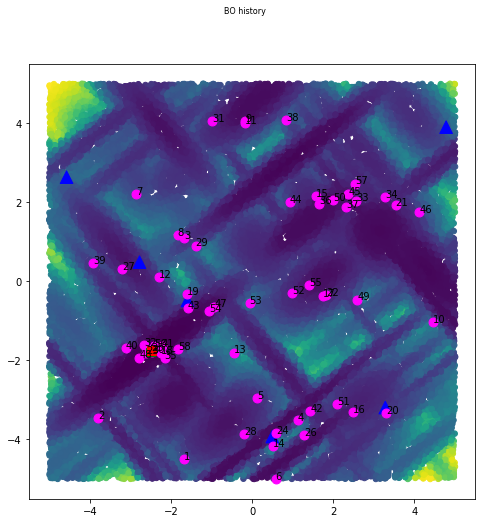

In [12]:
plt.rcParams["figure.figsize"] = (8, 8)

lhs_bo, lhs_xopt, _, lhs_best_regret = lhs_best_bo

result = {"initial_points": np.array(doe_lhs), "found_x": lhs_xopt}
plot_ei_performance(obj_func, samples, values, lhs_bo, result, marker_size=80)

In [13]:
lhs_best_regret

array([7.07136228e-06])

### sigma = 3.5

In [ ]:
doe35, es35 = cma_es_experiment(obj_func, doe_size, individual0=individual0, sigma0=3.5, n_test=3)

(5_w,11)-aCMA-ES (mu_w=3.4,w_1=42%) in dimension 12 (seed=1043419, Tue Nov  8 16:39:22 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     11 1.798336190546242e-02 1.0e+00 3.18e+00  3e+00  3e+00 6:35.0
    2     22 1.558162944993076e-04 1.1e+00 3.02e+00  3e+00  3e+00 13:15.7
    3     33 1.633995540335794e-03 1.2e+00 2.85e+00  3e+00  3e+00 19:33.4
    4     44 4.527941401171631e-03 1.2e+00 2.67e+00  3e+00  3e+00 25:49.5
    5     55 2.363904928086432e-03 1.3e+00 2.52e+00  2e+00  3e+00 32:08.1
    6     66 3.060705447120663e-02 1.3e+00 2.49e+00  2e+00  3e+00 38:16.3
    7     77 5.615742576002466e-04 1.3e+00 2.36e+00  2e+00  2e+00 44:32.7
    8     88 2.192573286936295e-02 1.3e+00 2.21e+00  2e+00  2e+00 50:32.1
    9     99 2.241050816320704e-02 1.4e+00 2.19e+00  2e+00  2e+00 56:56.1
   10    110 1.877746293525699e-03 1.4e+00 2.13e+00  2e+00  2e+00 63:26.8
   11    121 1.891915460700251e-02 1.4e+00 1.95e+00  2e+00  2e+00 70:04.7
   12    132 3.6358999

In [ ]:
regret, best_bo, worst_b = compute_regret(doe35, n=100)

#### DoE

In [16]:
doe35

[array([ 3.55693558, -5.        ]),
 array([-2.40906502, -1.4207859 ]),
 array([-1.7814405 ,  1.78681715]),
 array([1.14154662, 5.        ]),
 array([-2.63026103, -1.16657307]),
 array([-2.5309174 ,  4.21341615])]

In [18]:
regret

0.03336281557005371

#### AF performance plot

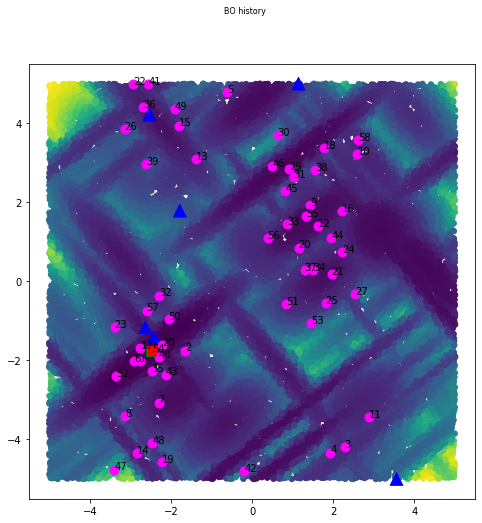

In [19]:
plt.rcParams["figure.figsize"] = (8,8)

bo, xopt, yopt, best_regret = best_bo

result = {"initial_points": np.array(doe35), "found_x": xopt}
plot_ei_performance(obj_func, samples, values, bo, result, marker_size=80)

In [20]:
best_regret

array([1.54481047e-06])

### sigma = 5 / 2 continue here


In [10]:
doe52, es52 = cma_es_experiment(obj_func, doe_size, individual0=individual0, sigma0=5/2, n_test=3)

(5_w,11)-aCMA-ES (mu_w=3.4,w_1=42%) in dimension 12 (seed=1160712, Wed Nov  9 09:31:22 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     11 2.829195596735208e-02 1.0e+00 2.25e+00  2e+00  2e+00 4:27.3
    2     22 1.634239951423903e-04 1.1e+00 2.11e+00  2e+00  2e+00 8:45.4
    3     33 1.048620974607672e-03 1.2e+00 2.01e+00  2e+00  2e+00 13:03.8
    4     44 1.487535705836507e-02 1.3e+00 1.97e+00  2e+00  2e+00 17:29.6
    5     55 1.336904804460914e-04 1.3e+00 1.98e+00  2e+00  2e+00 21:46.2
    6     66 1.565166389987572e-01 1.4e+00 1.91e+00  2e+00  2e+00 25:56.0
    7     77 3.720438803263448e-03 1.3e+00 1.90e+00  2e+00  2e+00 30:16.6
    8     88 1.042783528020408e-02 1.4e+00 1.87e+00  2e+00  2e+00 34:31.8
    9     99 4.183862464932038e-03 1.4e+00 1.91e+00  2e+00  2e+00 38:48.7
   10    110 1.004164286598552e-02 1.5e+00 1.96e+00  2e+00  2e+00 43:11.9
   11    121 3.177899230450976e-04 1.5e+00 1.89e+00  2e+00  2e+00 47:25.3
   12    132 3.57317945

In [13]:
regret, best_bo, worst_bo = compute_regret(doe52, n=100)

In [14]:
regret

0.0001335594374958049

#### AF performance plot

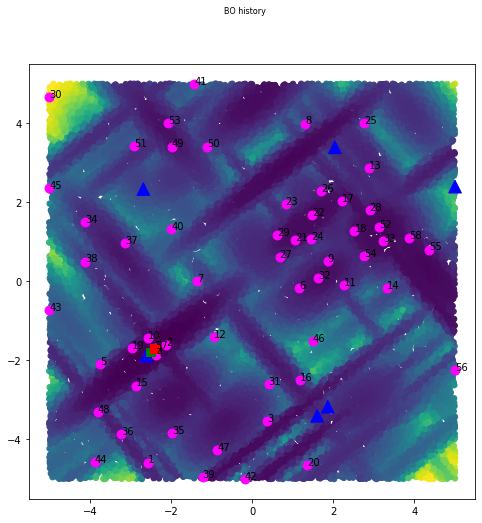

In [15]:
plt.rcParams["figure.figsize"] = (8, 8)

bo, xopt, yopt, best_regret = best_bo

space = RealSpace([lb, ub]) * dim
# Xs for test
samples = space.sample(n_samples)
# F(X)
values = obj_func(samples)
result = {"initial_points": np.array(doe52), "found_x": xopt}
plot_ei_performance(obj_func, samples, values, bo, result, marker_size=80)

In [16]:
best_regret

array([0.00012059])

#### DoE

In [12]:
doe52

[array([ 1.86365257, -3.1712427 ]),
 array([ 1.60498031, -3.39980024]),
 array([-2.68049143,  2.33589749]),
 array([5.      , 2.395419]),
 array([2.03803813, 3.3927012 ]),
 array([-2.60769227, -1.88287955])]

### sigma = 5 / 3

In [17]:
doe53, es53 = cma_es_experiment(obj_func, doe_size, individual0=individual0, sigma0=5/3, n_test=3)

(5_w,11)-aCMA-ES (mu_w=3.4,w_1=42%) in dimension 12 (seed=1159805, Wed Nov  9 11:29:13 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     11 1.269642737915149e-01 1.0e+00 1.60e+00  2e+00  2e+00 4:22.3
    2     22 5.132611261548921e-03 1.2e+00 1.50e+00  1e+00  2e+00 8:40.2
    3     33 4.425267172957585e-03 1.2e+00 1.39e+00  1e+00  1e+00 13:13.7
    4     44 6.321190605673858e-02 1.3e+00 1.33e+00  1e+00  1e+00 17:23.1
    5     55 9.130764180772151e-05 1.3e+00 1.28e+00  1e+00  1e+00 21:25.0
    6     66 5.288154191409451e-03 1.4e+00 1.23e+00  1e+00  1e+00 25:41.9
    7     77 8.755657971898737e-04 1.4e+00 1.15e+00  1e+00  1e+00 29:47.6
    8     88 6.853960658714205e-03 1.5e+00 1.10e+00  1e+00  1e+00 33:55.5
    9     99 3.204180027343758e-04 1.4e+00 1.09e+00  1e+00  1e+00 38:09.0
   10    110 6.884575033960042e-04 1.4e+00 1.05e+00  9e-01  1e+00 42:25.2
   11    121 2.343865893058705e-02 1.5e+00 9.38e-01  8e-01  1e+00 46:50.2
   12    132 2.26214521

In [21]:
regret, best_bo, worst_bo = compute_regret(doe53, n=100)

In [22]:
regret

0.3730142716183101

#### AF performance plot

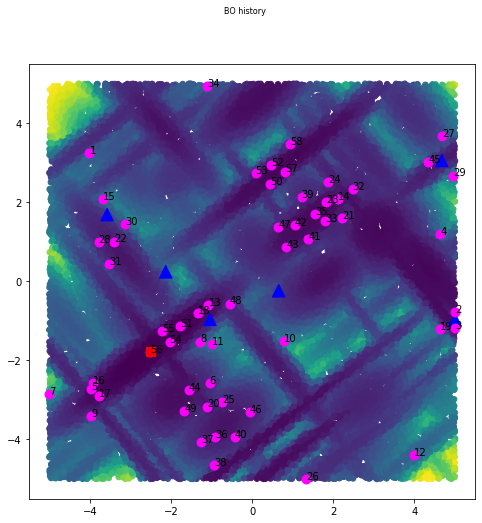

In [23]:
plt.rcParams["figure.figsize"] = (8,8)

bo, xopt, yopt, best_regret = best_bo

space = RealSpace([lb, ub]) * dim
# Xs for test
samples = space.sample(n_samples)
# F(X)
values = obj_func(samples)
result = {"initial_points": np.array(doe53), "found_x": xopt}
plot_ei_performance(obj_func, samples, values, bo, result, marker_size=80)

In [24]:
best_regret

array([1.6087327e-09])

In [25]:
_, _, _, max_regret = worst_bo
max_regret

array([2.05835377])

#### DoE

In [26]:
doe53

[array([ 5.        , -0.97003353]),
 array([-1.03985068, -0.96177136]),
 array([-3.57383614,  1.68845677]),
 array([4.67270262, 3.05682913]),
 array([ 0.65365193, -0.23758637]),
 array([-2.13087433,  0.24191133])]